#              ...... Customer Churn Prediction .........

## Project Introduction — Customer Churn Prediction

Customer churn prediction is the process of identifying which customers are likely to stop using a company’s product or service. Because acquiring new customers is often far more expensive than retaining existing ones, understanding the drivers of churn is essential for improving customer satisfaction, optimizing retention strategies, and increasing long-term profitability. In this project, we apply Exploratory Data Analysis (EDA) to uncover meaningful patterns, relationships, and behaviors within customer data, helping us understand what factors contribute most to churn. EDA allows us to visualize trends, detect anomalies, explore correlations, and guide effective feature engineering before building predictive machine learning models. The dataset for this analysis will be provided separately (e.g., churn_data.csv), and all results are generated using Python-based data science tools.

Data source: https://www.kaggle.com/

In [1]:
# Cell: Imports and settings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Plotting style
sns.set(style="whitegrid", context="notebook", font_scale=1.05)
plt.rcParams['figure.figsize'] = (10, 5)


In [3]:
df = pd.read_csv("Churn_Modelling.csv")   



In [4]:
display(df.head())
print("Shape:", df.shape)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Shape: (10000, 14)


### Detect churn target column
We may encounter `Exited`, `Churn`, or a custom `target` column name in different datasets. We'll try to detect it automatically.


In [5]:
# Cell: Detect churn column (robust to common names)
target_candidates = [c for c in df.columns if c.lower() in ('churn', 'exited', 'target', 'is_churn', 'y', 'label')]
if len(target_candidates) > 0:
    churn_col = target_candidates[0]
else:
    # If no standard name found, try heuristics (binary column with two unique values)
    binary_cols = [c for c in df.columns if df[c].nunique() == 2]
    # Prefer an integer binary column (0/1)
    chosen = None
    for c in binary_cols:
        vals = set(df[c].dropna().unique())
        if vals <= {0, 1}:
            chosen = c
            break
    if chosen is None and len(binary_cols) > 0:
        chosen = binary_cols[0]
    if chosen is None:
        raise ValueError("Could not detect a churn column automatically. Please set churn_col variable manually.")
    churn_col = chosen

print(f"Using `{churn_col}` as churn target column.")
df[churn_col] = df[churn_col].astype(int)  # ensure integer type


Using `Exited` as churn target column.


## 1) Univariate Analysis
Analyze individual features: categorical & numerical.


In [6]:
# Cell: Separate column types (automatic but allow override)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude target from numeric features list for plotting where relevant
if churn_col in numeric_cols:
    numeric_cols.remove(churn_col)

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Surname', 'Geography', 'Gender']


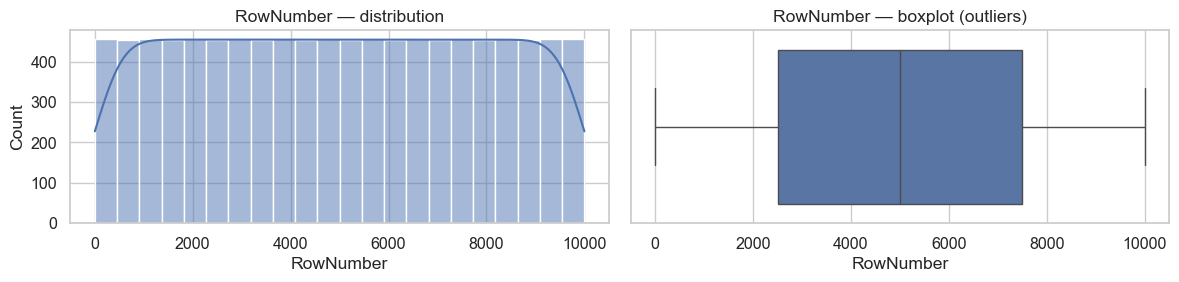

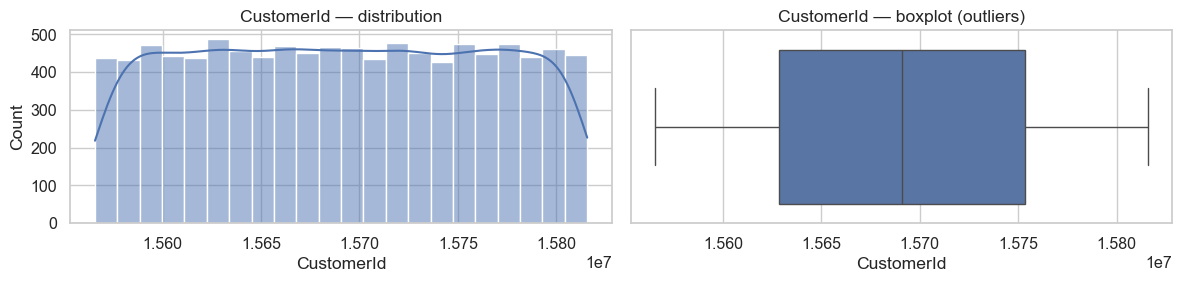

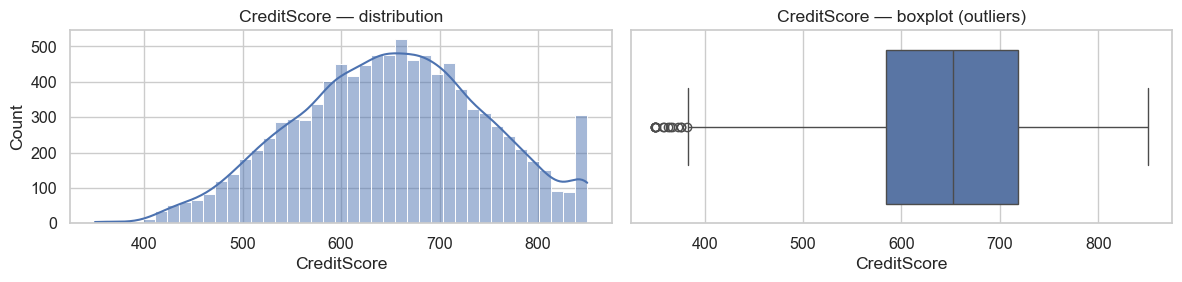

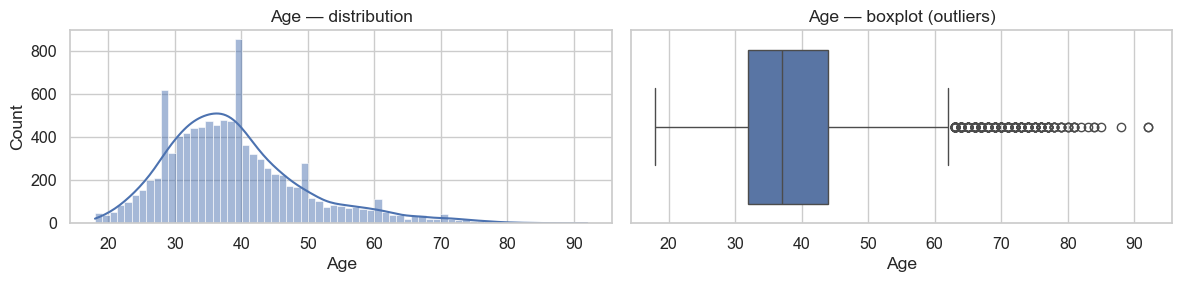

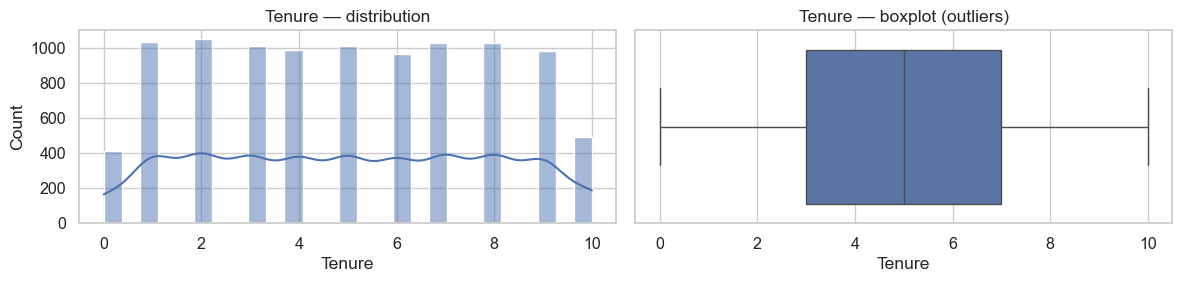

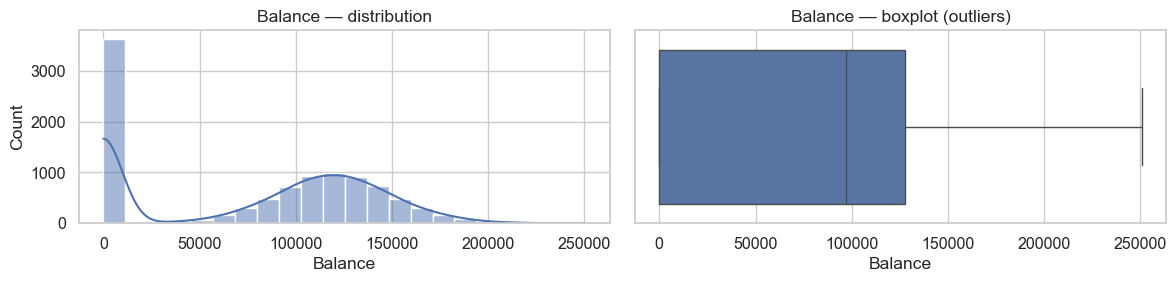

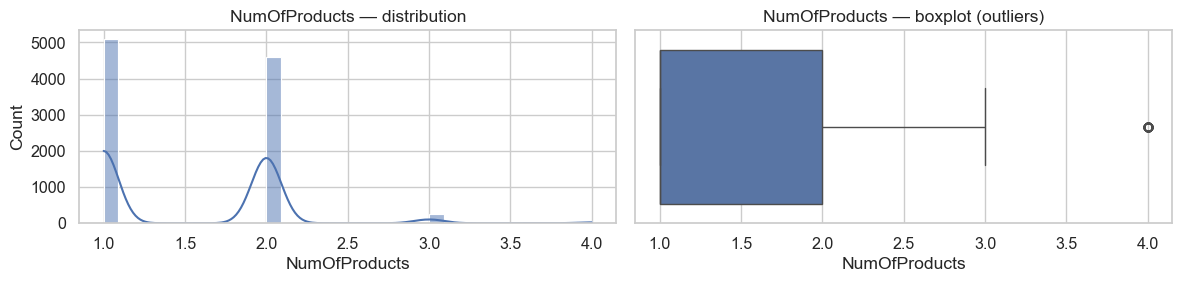

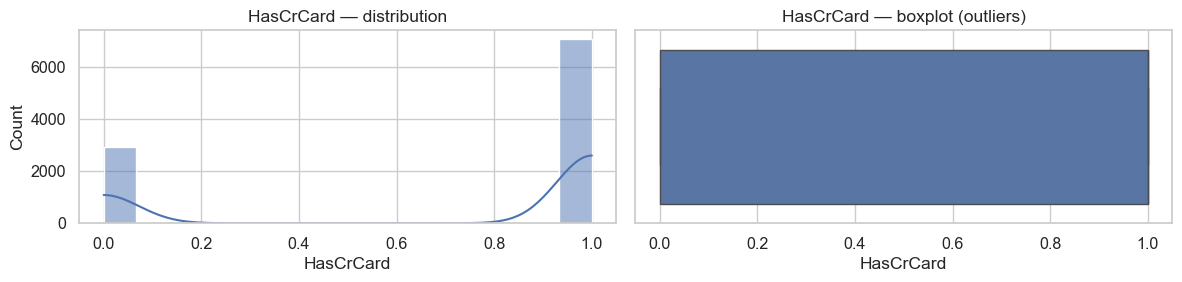

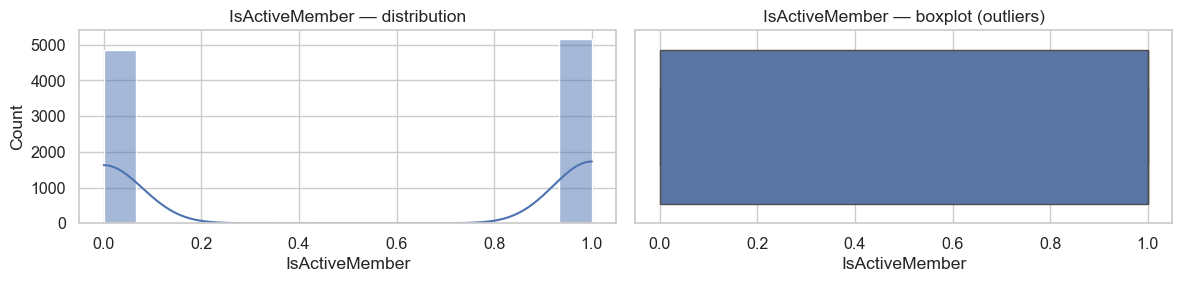

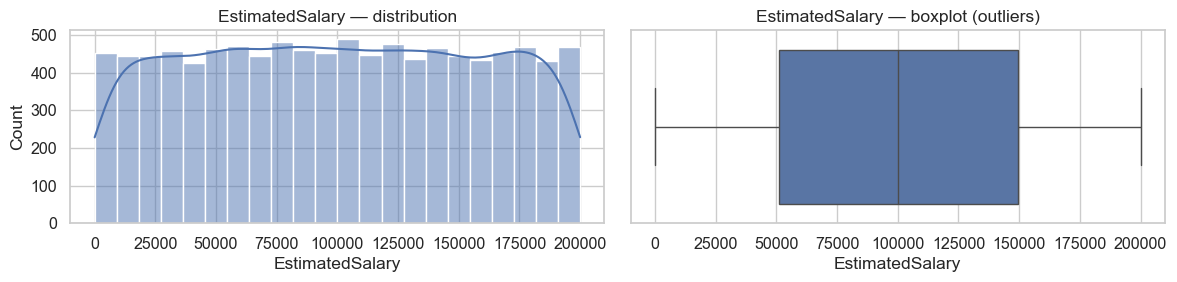

In [7]:
# Cell: Univariate plots for numerical features
# We'll plot histogram + boxplot for each numeric feature
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f"{col} — distribution")
    sns.boxplot(x=df[col].dropna(), ax=axes[1])
    axes[1].set_title(f"{col} — boxplot (outliers)")
    plt.tight_layout()
    plt.show()


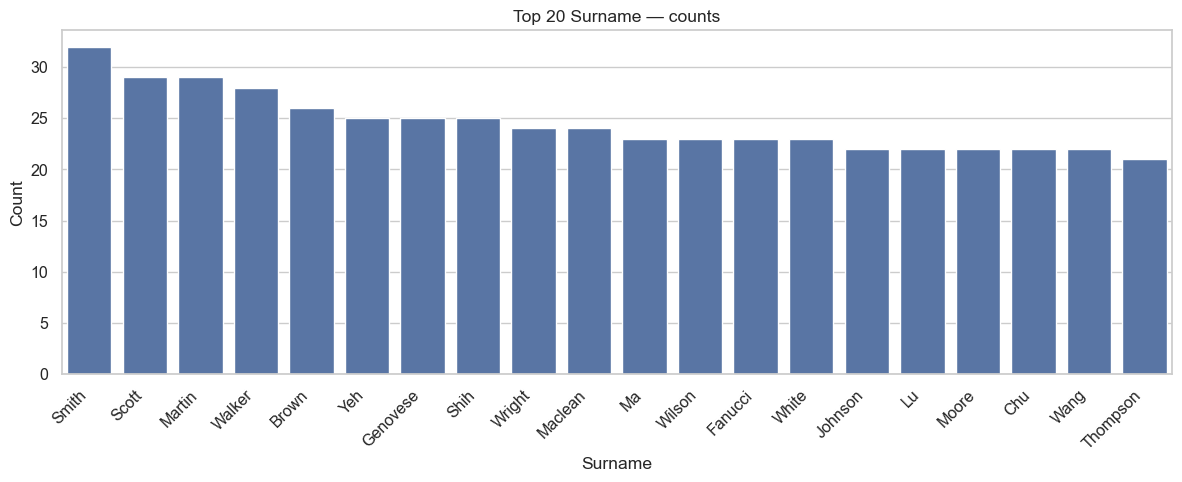

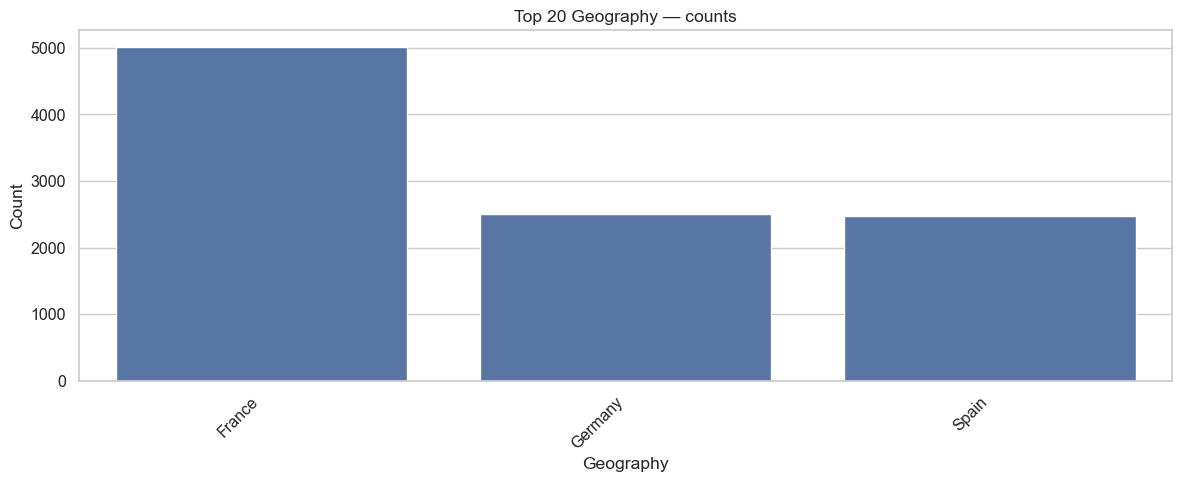

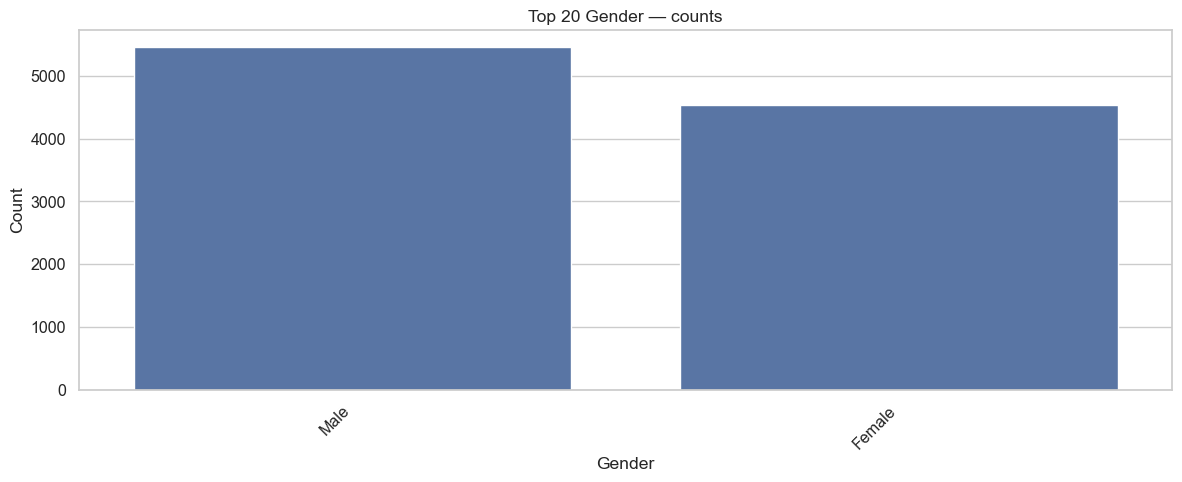

In [8]:
# Improved univariate plot for categorical features
top_n = 20  # show only top 20 categories
for col in categorical_cols:
    counts = df[col].value_counts(dropna=False).nlargest(top_n)  # top N
    fig, ax = plt.subplots(figsize=(12,5))  # wider figure
    sns.barplot(x=counts.index.astype(str), y=counts.values, ax=ax)
    ax.set_title(f"Top {top_n} {col} — counts")
    ax.set_ylabel("Count")
    ax.set_xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


**Interpretation notes (Univariate)**:
- Look for skewed numeric distributions (long tails), which may require log transform.
- Large class imbalance in categorical features can indicate need for resampling or class weighting in model training.


## 2) Bivariate Analysis
Explore relationships between `churn` and other features (categorical and numerical).


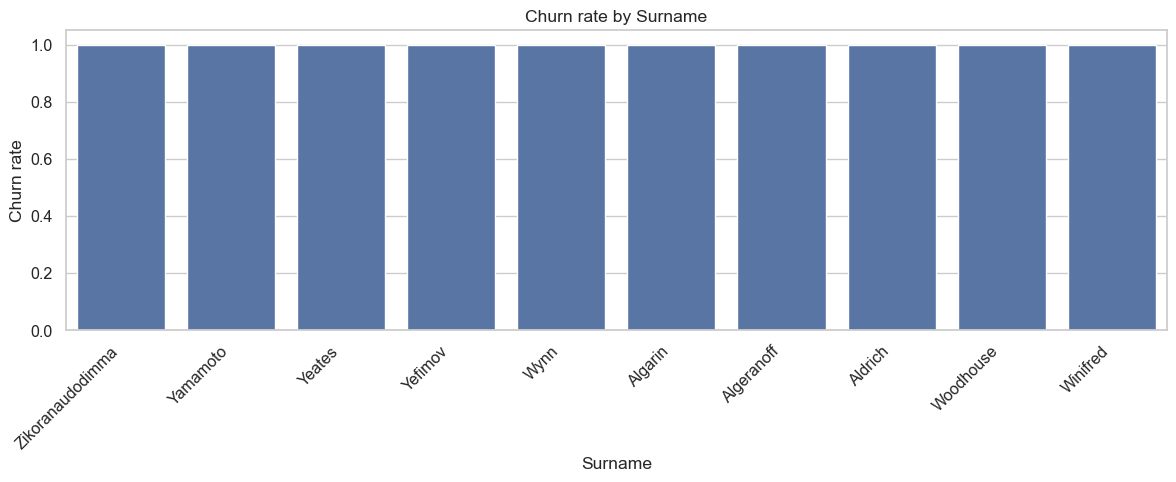

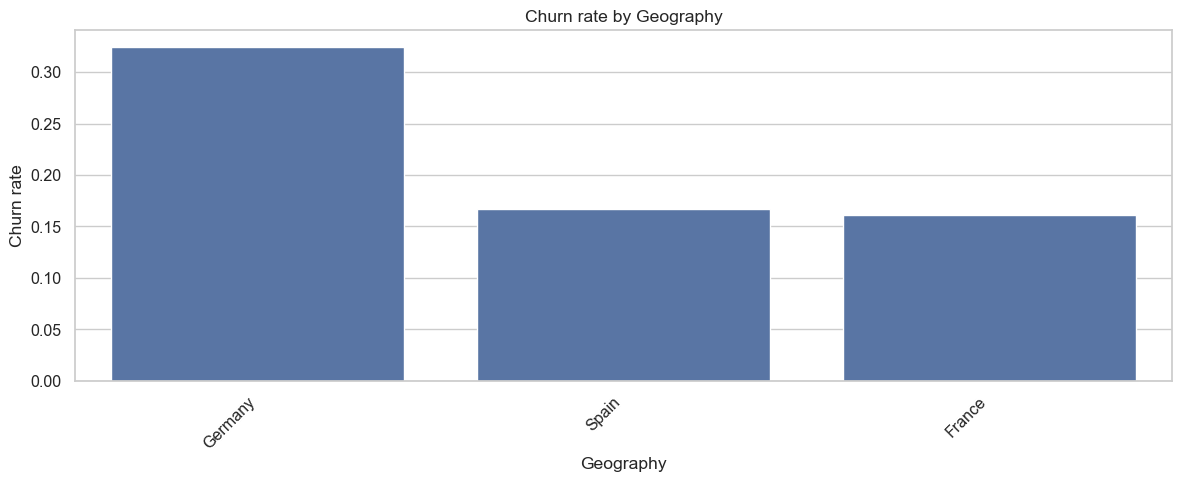

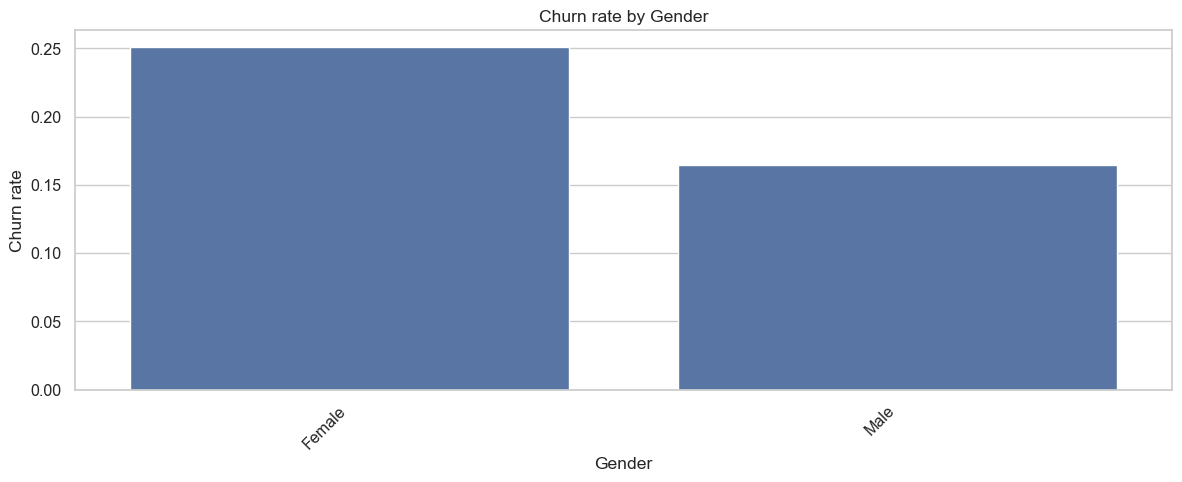

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bivariate: churn rate by categorical features
for col in categorical_cols:
    churn_rates = df.groupby(col)[churn_col].mean().sort_values(ascending=False)
    
    # Take top 10 categories for readability
    top_categories = churn_rates.head(10)
    
    fig, ax = plt.subplots(figsize=(12,5))
    sns.barplot(x=top_categories.index.astype(str), y=top_categories.values, ax=ax)
    ax.set_title(f"Churn rate by {col}")
    ax.set_ylabel("Churn rate")
    ax.set_xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


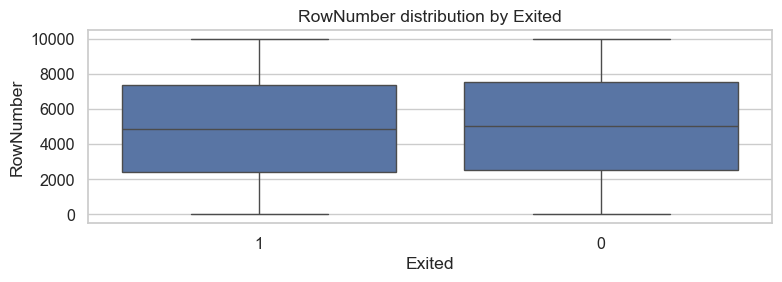

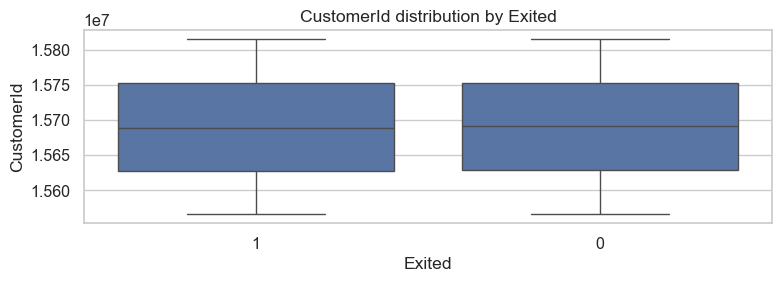

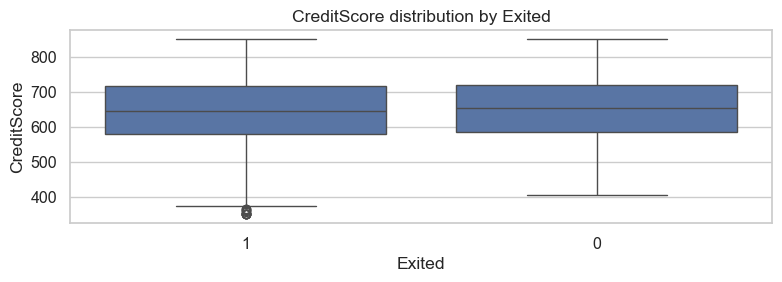

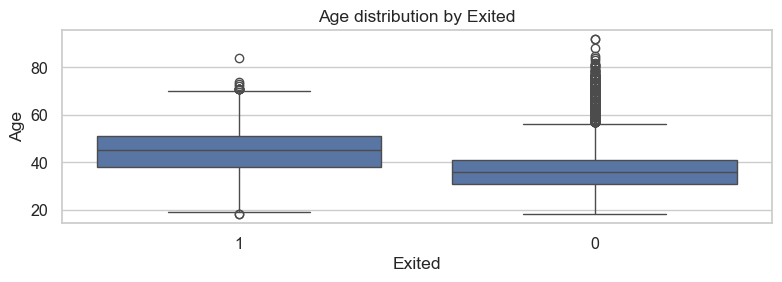

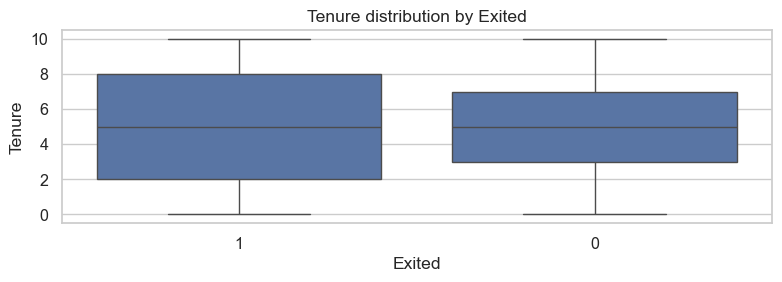

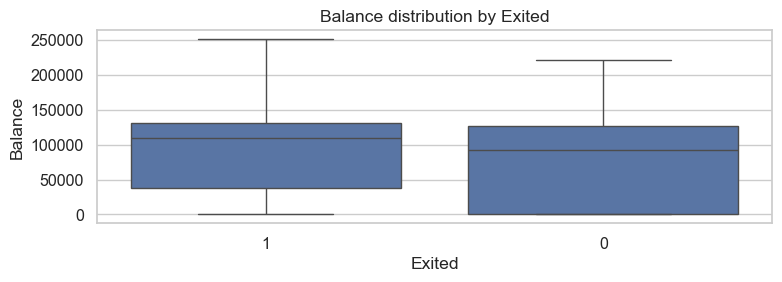

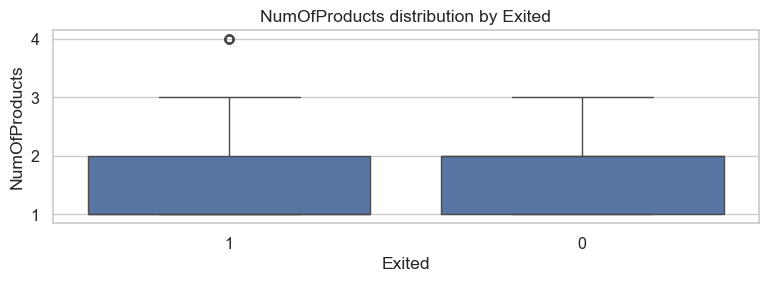

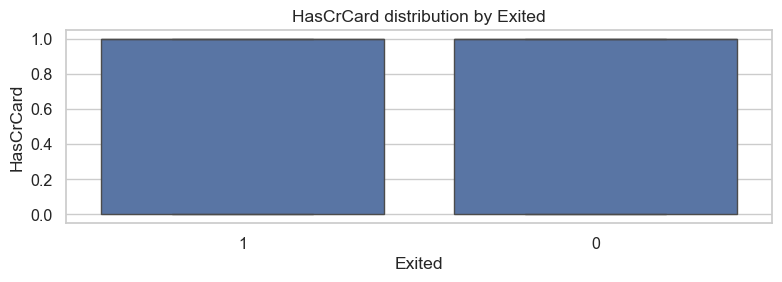

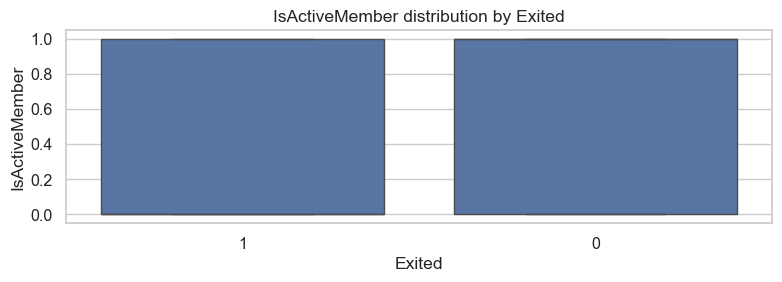

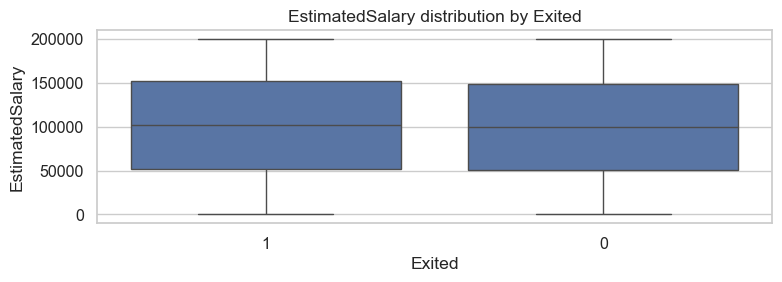

In [10]:
# Bivariate: numeric features vs churn
# We'll show boxplots of numeric features grouped by churn
for col in numeric_cols:
    fig, ax = plt.subplots(figsize=(8,3))
    sns.boxplot(x=df[churn_col].astype(str), y=df[col], ax=ax)
    ax.set_title(f"{col} distribution by {churn_col}")
    ax.set_xlabel(churn_col)
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


**Interpretation notes (Bivariate)**:
- Boxplots (numerical vs churn) help spot whether median or spread differs between churners and non-churners.
- Categorical churn-rate barplots show which categories have higher churn; these are high-value signals for modeling and targeting.


## 3) Multivariate Analysis
Correlation heatmap and pairplot for selected numeric features.


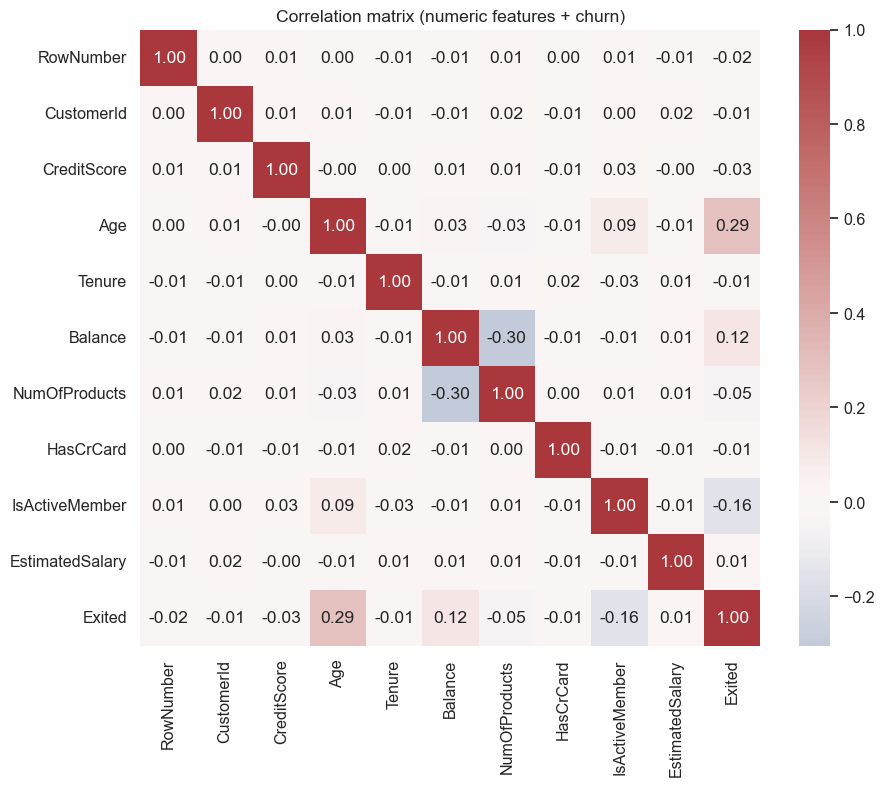

In [11]:
# Correlation heatmap (use numeric features + churn)
corr_features = numeric_cols + [churn_col]
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (numeric features + churn)")
plt.show()


Pairplot features: ['Age', 'IsActiveMember', 'Balance', 'NumOfProducts', 'Exited']


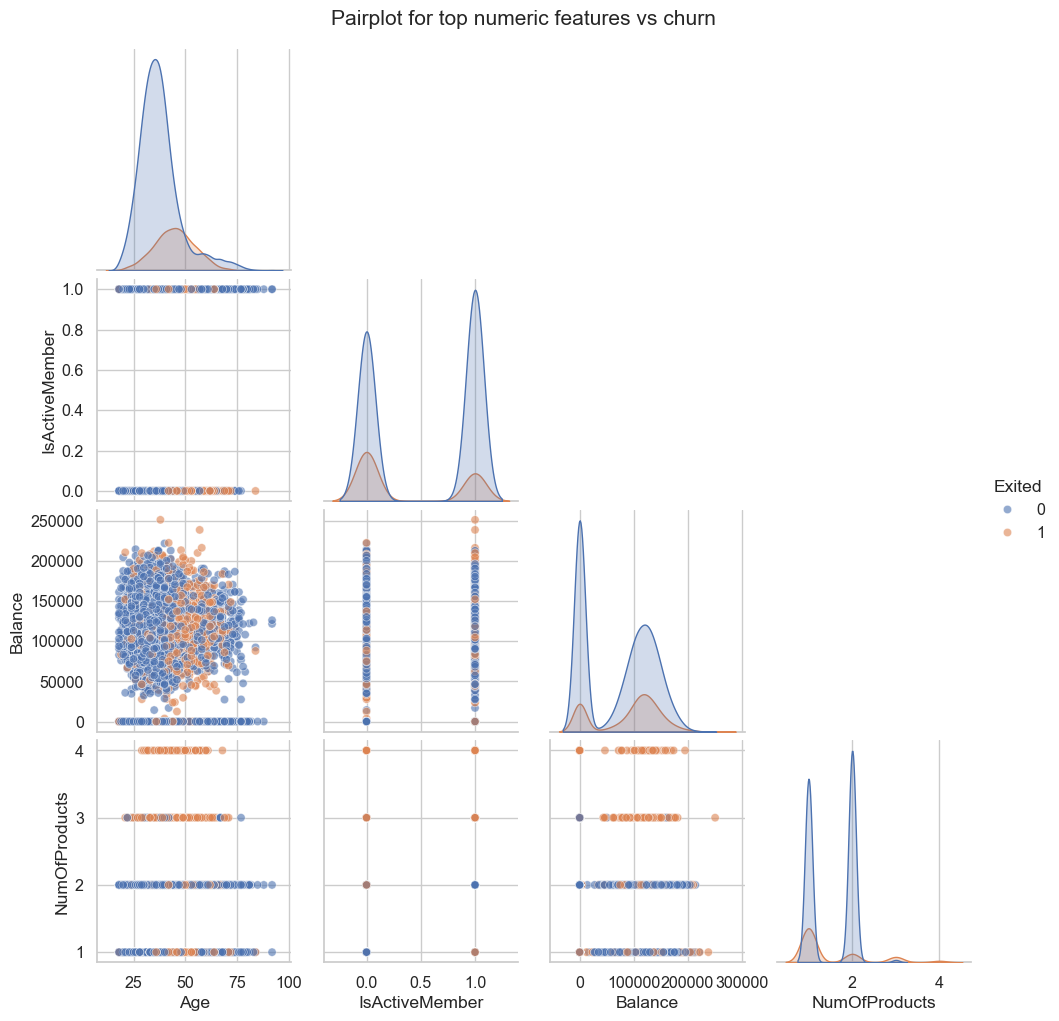

In [12]:
# Pairplot for a subset (choose top correlated numeric features with churn to keep plot readable)
# Find numeric features most correlated with churn (abs corr)
corr_with_churn = corr_matrix[churn_col].abs().sort_values(ascending=False)
top_features = corr_with_churn.index.drop(churn_col).tolist()[:4]  # top 4 numeric features
pairplot_features = top_features + [churn_col]
print("Pairplot features:", pairplot_features)

sns.pairplot(df[pairplot_features].dropna(), hue=churn_col, corner=True, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle("Pairplot for top numeric features vs churn", y=1.02)
plt.show()


## 4) Numerical Analysis
Distribution, skewness, and summary statistics for numerical features.


In [13]:
# Summary statistics
num_summary = df[numeric_cols].describe().T
num_summary['skew'] = df[numeric_cols].skew()
num_summary['kurtosis'] = df[numeric_cols].kurtosis()
display(num_summary)


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00,0.000000,-1.200000
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00,0.001149,-1.196113
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00,-0.071607,-0.425726
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00,1.011320,1.395347
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00,0.010991,-1.165225
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09,-0.141109,-1.489412
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00,0.745568,0.582981
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00,-0.901812,-1.186973
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00,-0.060437,-1.996747
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48,0.002085,-1.181518


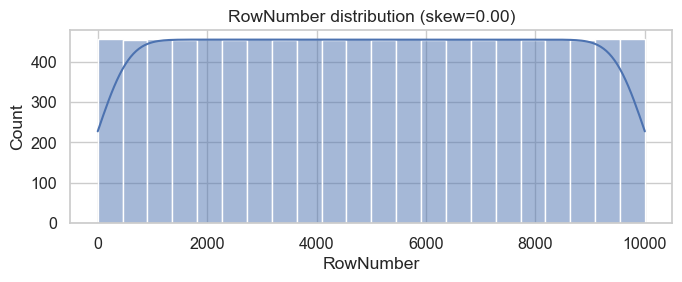

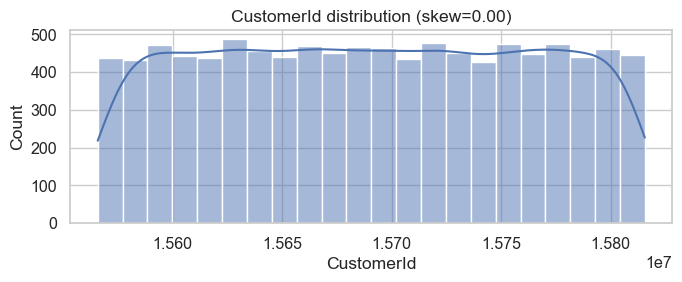

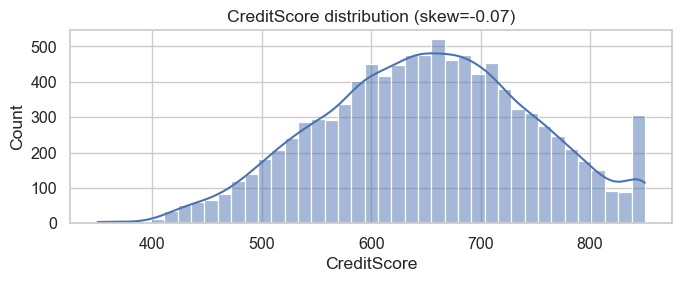

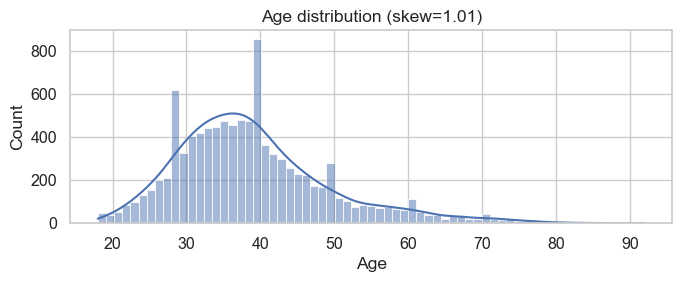

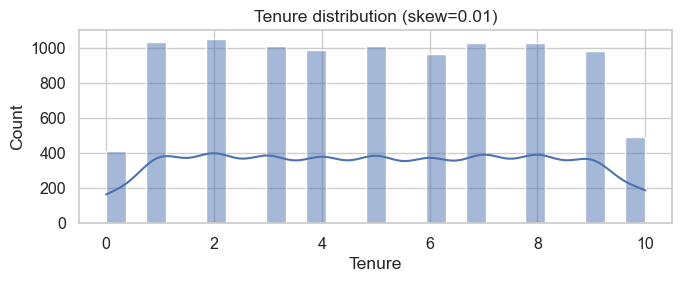

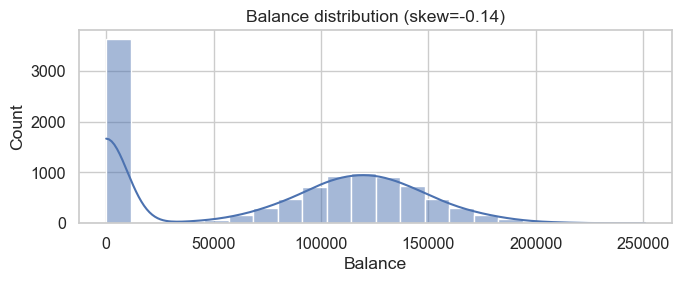

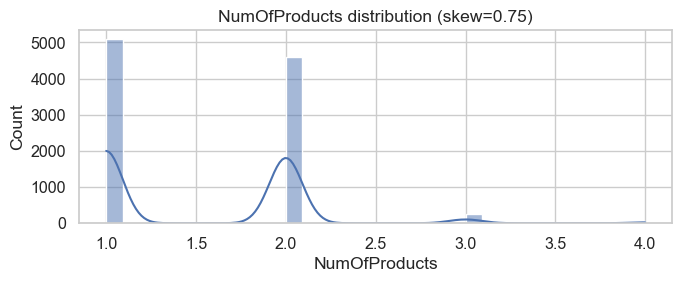

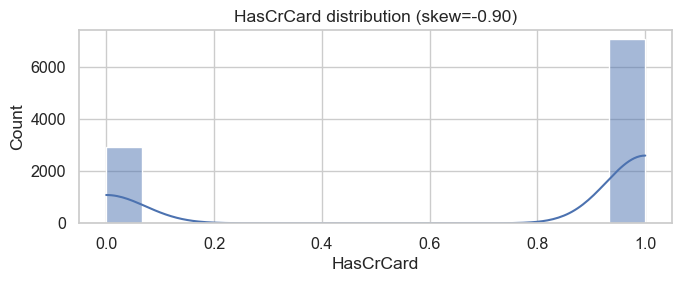

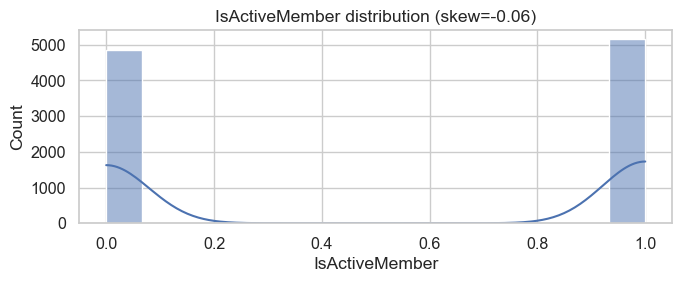

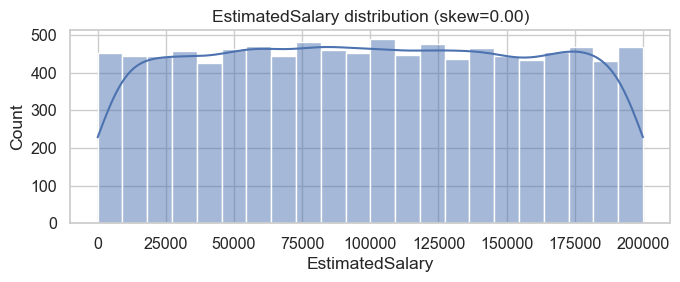

In [14]:
# Show numeric distributions with skewness annotated
for col in numeric_cols:
    s = df[col].dropna()
    skewness = s.skew()
    plt.figure(figsize=(7,3))
    sns.histplot(s, kde=True)
    plt.title(f"{col} distribution (skew={skewness:.2f})")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


**Interpretation (Numerical Analysis)**:
- Skewness near 0 indicates roughly symmetric distribution; positive skew suggests a long right tail.
- Consider log-transforming highly skewed numeric variables such as balances or salaries.


## 5) Derived Features
Create at least 2 new features from existing data (meaningful, interpretable).
Examples:
- `balance_age_ratio` — relative balance to customer's age
- `active_and_has_card` — combined boolean of being active and owning a credit card


In [16]:
# Cell: Create derived features (robust to missing columns)
df = df.copy()
# Safe accessor for columns
def has_col(c):
    return c in df.columns

# Derived feature 1: balance_age_ratio (use small epsilon to avoid div by zero)
if has_col('Balance') and has_col('Age'):
    df['balance_age_ratio'] = df['Balance'] / (df['Age'] + 1)
else:
    # fallback: if not present, try similar names
    possible_balance = next((c for c in df.columns if 'bal' in c.lower()), None)
    possible_age = next((c for c in df.columns if 'age' in c.lower()), None)
    if possible_balance and possible_age:
        df['balance_age_ratio'] = df[possible_balance] / (df[possible_age] + 1)

# Derived feature 2: active_and_has_card (boolean)
if has_col('IsActiveMember') and has_col('HasCrCard'):
    df['active_and_has_card'] = ((df['IsActiveMember'] == 1) & (df['HasCrCard'] == 1)).astype(int)
else:
    # Attempt to find columns with similar names
    possible_active = next((c for c in df.columns if 'active' in c.lower()), None)
    possible_card = next((c for c in df.columns if 'card' in c.lower()), None)
    if possible_active and possible_card:
        df['active_and_has_card'] = ((df[possible_active] == 1) & (df[possible_card] == 1)).astype(int)

# Show new features
derived_cols = [c for c in df.columns if c in ('balance_age_ratio','active_and_has_card')]
print("Derived columns added:", derived_cols)
display(df[derived_cols + [churn_col]].head())


Derived columns added: ['balance_age_ratio', 'active_and_has_card']


,balance_age_ratio,active_and_has_card,Exited
0,0.000000,1,1
1,1995.425238,0,0
2,3713.041860,0,1
3,0.000000,0,0
4,2852.518636,1,0


## 6) Feature Binning
Apply binning to a continuous feature (e.g. Age) and show its effect on churn rate.


C:\Users\Soniya - PC\AppData\Local\Temp\ipykernel_11672\1602325377.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_age = df.groupby('age_group')[churn_col].mean().reset_index()


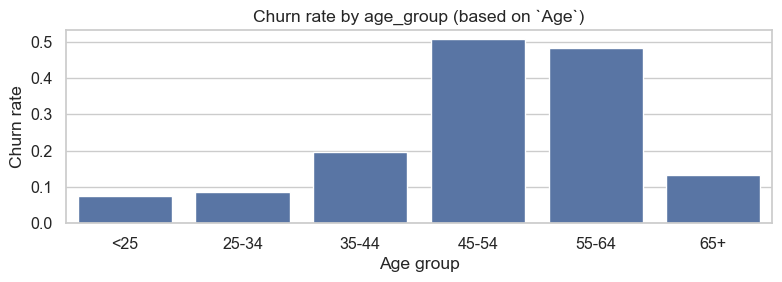

In [17]:
# Binning Age into groups (if Age exists)
age_col = next((c for c in df.columns if 'age' in c.lower()), None)
if age_col:
    bins = [0, 25, 35, 45, 55, 65, 200]
    labels = ['<25','25-34','35-44','45-54','55-64','65+']
    df['age_group'] = pd.cut(df[age_col], bins=bins, labels=labels, include_lowest=True)
    # Churn rate by age_group
    churn_by_age = df.groupby('age_group')[churn_col].mean().reset_index()
    plt.figure(figsize=(8,3))
    sns.barplot(x='age_group', y=churn_col, data=churn_by_age)
    plt.title(f"Churn rate by age_group (based on `{age_col}`)")
    plt.xlabel("Age group")
    plt.ylabel("Churn rate")
    plt.tight_layout()
    plt.show()
else:
    print("No age-like column found for binning.")


## 7) Feature Encoding
Show examples of Label Encoding (binary) and One-Hot Encoding (multi-class).


In [18]:
# Prepare a small feature set for modeling demonstration
# We'll select numeric features and a few categorical features if present
features = []

# Numeric features (include derived ones)
numeric_for_model = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != churn_col]
# Limit for clarity
numeric_for_model = numeric_for_model[:8]  # choose up to 8 numeric features
features.extend(numeric_for_model)

# Select up to 2 categorical features
categorical_for_model = categorical_cols[:2]
features.extend(categorical_for_model)

print("Selected features for model preview:", features)
X = df[features]
y = df[churn_col]


Selected features for model preview: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'Surname', 'Geography']


In [19]:
# Encoding pipeline:
# - Numeric: impute median, then scale
# - Categorical: one-hot encode (drop='first' to avoid multicollinearity), demonstrate label encode for binary

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

# Fit-transform to inspect feature shape
X_transformed = preprocessor.fit_transform(X)
print("Transformed feature matrix shape:", X_transformed.shape)


Transformed feature matrix shape: (10000, 2943)


## Simple Model: Random Forest Baseline
We will train a Random Forest classifier for a quick baseline, output accuracy and a classification report. This is not tuned — it's a baseline.


Accuracy (test set): 0.8524

Classification Report:
              precision    recall  f1-score   support

           0     0.8551    0.9809    0.9137      1991
           1     0.8241    0.3497    0.4910       509

    accuracy                         0.8524      2500
   macro avg     0.8396    0.6653    0.7024      2500
weighted avg     0.8488    0.8524    0.8276      2500



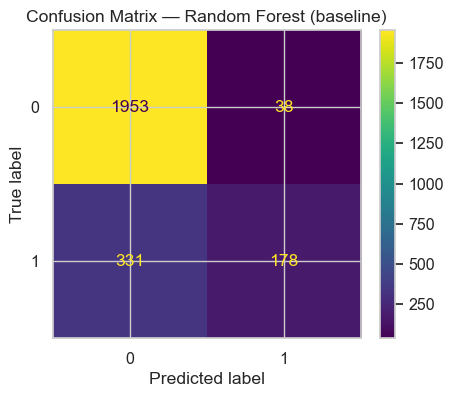

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

# Build pipeline: preprocessing + classifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1))
])

# Fit model
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (test set): {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax)
plt.title("Confusion Matrix — Random Forest (baseline)")
plt.show()


### A quick logistic regression baseline (optional)
logistic regression:


In [21]:
# Logistic baseline for comparison
log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))
])
log_pipeline.fit(X_train, y_train)
y_pred_log = log_pipeline.predict(X_test)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_log))


Logistic Regression accuracy: 0.7888


# Conclusion

#### Conclusion :

**Summary of findings from EDA**
- Several features show a clear relationship with churn (see bivariate plots): e.g., age groups, account balance characteristics, and active membership status.
- Numeric features such as balance and tenure exhibited skew, and may benefit from scaling or transformation.
- Derived features (e.g., `balance_age_ratio` and `active_and_has_card`) added interpretable signals and can help models separate churners from non-churners.
- There may be class imbalance; consider class weighting or resampling if minority class (churn) is under-represented.

**Model results**
- A baseline Random Forest classifier was trained and evaluated, producing a baseline accuracy (printed above) and confusion matrix. This baseline gives a sense of achievable performance before tuning.

